In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import sqlalchemy
from dotenv import load_dotenv
import os
from mylib.db import pandas_to_sql_with_unique_index, create_engine_from_sqlite_path

from mylib.db import get_table_object

## 読み込み

In [17]:
data_directory = Path("../data/inputs/")
dict_csv_files = {p.stem: p for p in data_directory.rglob("*.csv")}
dict_csv_files

{'sample_submission': PosixPath('../data/inputs/sample_submission.csv'),
 'test': PosixPath('../data/inputs/test.csv'),
 'train': PosixPath('../data/inputs/train.csv')}

In [18]:
df_train = pd.read_csv(dict_csv_files["train"])
df_test = pd.read_csv(dict_csv_files["test"])
df_submission = pd.read_csv(dict_csv_files["sample_submission"])

## 確認

head

In [8]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [9]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


info

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


describe

In [13]:
df_train.describe(include="all")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,9280_02,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Ankalik Nateansive,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


In [14]:
df_test.describe(include="all")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
count,4277,4190,4184,4177,4185,4186.000000,4184,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000,4183
unique,4277,3,2,3265,3,NaN,2,NaN,NaN,NaN,NaN,NaN,4176
top,9277_01,Earth,False,G/160/P,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Cints Erle
freq,1,2263,2640,8,2956,NaN,4110,NaN,NaN,NaN,NaN,NaN,2
mean,NaN,NaN,NaN,NaN,NaN,28.658146,NaN,219.266269,439.484296,177.295525,303.052443,310.710031,NaN
std,NaN,NaN,NaN,NaN,NaN,14.179072,NaN,607.011289,1527.663045,560.821123,1117.186015,1246.994742,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,37.000000,NaN,53.000000,78.000000,33.000000,50.000000,36.000000,NaN


null

In [15]:
df_train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

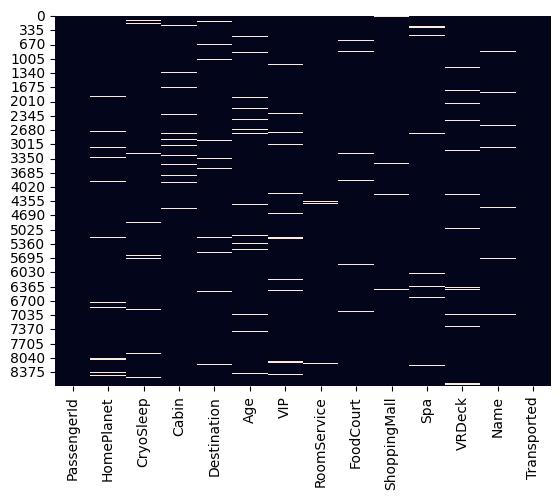

In [18]:
_ = sns.heatmap(df_train.isna(), cbar=False)

In [19]:
df_test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

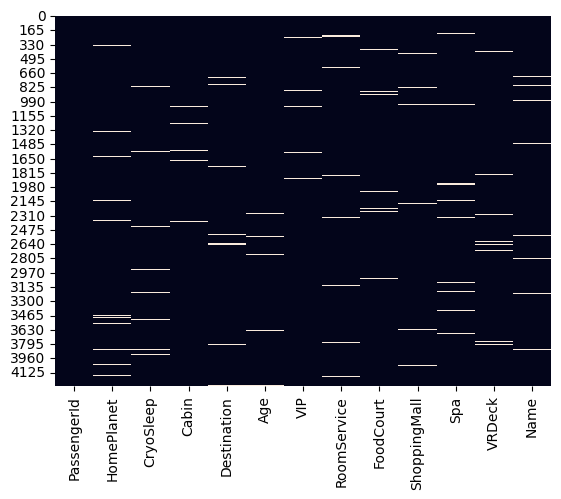

In [20]:
_ = sns.heatmap(df_test.isna(), cbar=False)